In [1]:
from __future__ import print_function
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

%matplotlib inline

/Users/ocksumoron/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [3]:
X = train[train['shift'] == 1].drop(['Num','y','shift'], axis=1)
y = train[train['shift'] == 1]['y']
print(len(X), len(y))

24385 24385


In [4]:
def get_k(item_id, year):
    vals = []
    ys = []
    data = train[(train['item_id'] == item_id) & (train['year'] == year) & (train['shift'] == 1)].sort_values('week')
    if (data.shape[0] == 0):
        return 1.0
    ys.append(data.iloc[0]['y'])
    vals.append(data.iloc[0]['f60'])
    
    for i in range(1, data.shape[0]):
        vals.append(data.iloc[i]['f60'])
        ys.append(data.iloc[i]['y'])
        
    vals = np.array(vals)
    ys = np.array(ys)
    k = np.median(vals[1:] / ys[:-1])
    return k

ks_2013 = {}
ks_2014 = {}

for item_id in test['item_id'].unique():
    ks_2013[item_id] = get_k(item_id, 2013)
    ks_2014[item_id] = get_k(item_id, 2014)
    
best_k = (np.median(list(ks_2013.values())) + np.median(list(ks_2014.values()))) * 0.5

y *= best_k

In [5]:
X_13, y_13 = X[X['year'] == 2013], y[X['year'] == 2013]
X_14, y_14 = X[(X['year'] == 2014) & (X['week'] <= 50)], y[(X['year'] == 2014) & (X['week'] <= 50)]

In [6]:
def feature_gen():
    features = ['f' + str(i) for i in range(55, 61)]
    for i, row in X_14.iterrows():
        prev_vals = X_13[(X_13['item_id'] == row['item_id']) & \
                         (X_13['week'] == row['week'] + 2)]
        
        if prev_vals.shape[0] == 0:
            for f in ['f' + str(j) for j in range(55, 61)]:
                X_14.set_value(i, 'prev_' + f, 0.0)
                
            continue
            
        
        prev_val = prev_vals.iloc[0]
        
        for f in ['f' + str(j) for j in range(55, 61)]:
            X_14.set_value(i, 'prev_' + f, prev_val[f])
            
            
    for i, row in test.iterrows():
        prev_vals = X_14[(X_14['item_id'] == row['item_id']) & \
                         (X_14['week'] == row['week'] + 2)]
        
        if prev_vals.shape[0] == 0:
            for f in ['f' + str(j) for j in range(55, 61)]:
                test.set_value(i, 'prev_' + f, 0.0)
                
            continue
        
        prev_val = prev_vals.iloc[0]
        
        for f in ['f' + str(j) for j in range(55, 61)]:
            test.set_value(i, 'prev_' + f, prev_val[f])
    
    features += ['prev_f' + str(i) for i in range(55, 61)]
    return features

In [7]:
features = feature_gen()

/Users/ocksumoron/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ocksumoron/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
X_train, y_train = X_14[X_14['week'] < 40], y_14[X_14['week'] < 40]
X_val, y_val = X_14[X_14['week'] >= 40], y_14[X_14['week'] >= 40]

In [9]:
def get_smape(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    n = len(y_pred)
    return 100. / n * np.sum(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def get_smape_d(y_pred, d_y_true):
    y_true = d_y_true.get_label()
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    n = len(y_pred)
    return 'smape', 100. / n * np.sum(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [87]:
param = {}
param['max_depth'] = 15
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eta'] = 0.05
param['colsample_bytree'] = 1
param['subsample'] = 0.8

numround = 2001

In [89]:
%%time
#Xdata = xgb.DMatrix(data = X[features], label = y)
Xdatatrain = xgb.DMatrix(data = X_train[features], label = y_train)
Xdatatest = xgb.DMatrix(data = X_val[features], label = y_val)

plst = list(param.items())
watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            

output = {}

bst = xgb.train(plst, Xdatatrain, numround, feval=get_smape_d, evals=watchlist, evals_result=output, verbose_eval=100)
# ypredxgb_tr = bst.predict(Xdatatrain)

[0]	train-smape:89.8795	eval-smape:88.767
[100]	train-smape:3.8602	eval-smape:14.3006
[200]	train-smape:4.01799	eval-smape:14.5061
[300]	train-smape:3.51311	eval-smape:14.4481
[400]	train-smape:2.96415	eval-smape:14.5934
[500]	train-smape:2.56326	eval-smape:14.5526
[600]	train-smape:2.0909	eval-smape:14.6037
[700]	train-smape:1.73367	eval-smape:14.6019
[800]	train-smape:1.35807	eval-smape:14.6326
[900]	train-smape:1.00322	eval-smape:14.6459
[1000]	train-smape:0.798811	eval-smape:14.6189
[1100]	train-smape:0.648265	eval-smape:14.6528
[1200]	train-smape:0.518767	eval-smape:14.6299
[1300]	train-smape:0.431089	eval-smape:14.6764
[1400]	train-smape:0.416075	eval-smape:14.7061
[1500]	train-smape:0.365439	eval-smape:14.6592
[1600]	train-smape:0.33548	eval-smape:14.6558
[1700]	train-smape:0.327377	eval-smape:14.6469
[1800]	train-smape:0.323039	eval-smape:14.6212
[1900]	train-smape:0.30874	eval-smape:14.6947
[2000]	train-smape:0.315407	eval-smape:14.6953
CPU times: user 54.8 s, sys: 373 ms, tot

In [85]:
def grid_search():
    max_depths = [3, 4, 5, 6, 7, 8, 10, 12, 15]
    learning_rates = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.13, 0.15, 0.17, 0.2]
    subsamples = [0.8, 0.9, 1]
    colsample_bytrees = [0.8, 0.9, 1]
    
    
    numround = 2001
    
    best_q = 15.0
    
    for max_depth in max_depths:
        
        print("MAX_DEPTH =", max_depth)
        
        with open("output" + str(max_depth), 'w') as f:
        
            for learning_rate in learning_rates:

                print("LEARNING_RATE =", learning_rate)

                for subsample in subsamples:

                    print ("SUBSAMPLE =", subsample)

                    for colsample_bytree in colsample_bytrees:

                        print ("COLSAMPLE_BYTREE =", colsample_bytree)
                        
                        param = {}
                        param['max_depth'] = max_depth
                        param['booster'] = 'gbtree'
                        param['objective'] = 'reg:linear'
                        param['eta'] = learning_rate
                        param['colsample_bytree'] = colsample_bytree
                        param['subsample'] = subsample
                        
                        plst = list(param.items())
                            
                        output = {}

                        bst = xgb.train(plst, Xdatatrain, \
                                        numround, feval=get_smape_d, \
                                        evals=watchlist, evals_result=output, \
                                        verbose_eval=False)
                        
                        f.write("LEARNING_RATE =" + str(learning_rate) + \
                                ", SUBSAMPLE =" + str(subsample) + \
                                ", COLSAMPLE_BYTREE =" + str(colsample_bytree) + "\n")
            
                        output_smape = output['eval']['smape']
                        
                        for i in range(0, len(output_smape), 100):
                            f.write(str(i) + ": " + str(output_smape[i]) + "\n")
                            if (output_smape[i] < best_q):
                                best_q = output_smape[i]
                                print("BEST = " + str(best_q))
                                

In [86]:
%%time
grid_search()

MAX_DEPTH = 3
LEARNING_RATE = 0.05
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 0.9
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 1
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
LEARNING_RATE = 0.06
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 0.9
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 1
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
LEARNING_RATE = 0.07
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 0.9
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 1
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
LEARNING_RATE = 0.08
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 0.9
COLSAMPLE_BYTREE = 0.8
COLSAMPLE_BYTREE = 0.9
COLSAMPLE_BYTREE

In [ ]:
def grid_search():
    max_depths = [3, 4, 5, 6, 7, 8, 10, 12, 15]
    learning_rates = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.13, 0.15, 0.17, 0.2]
    subsamples = [0.8, 0.9, 1]
    colsample_bytrees = [0.8, 0.9, 1]
    
    
    numround = 2001
    
    best_q = 15.0
    
    for max_depth in max_depths:
        
        print("MAX_DEPTH =", max_depth)
        
        with open("output" + str(max_depth), 'w') as f:
        
            for learning_rate in learning_rates:

                print("LEARNING_RATE =", learning_rate)

                for subsample in subsamples:

                    print ("SUBSAMPLE =", subsample)

                    for colsample_bytree in colsample_bytrees:

                        print ("COLSAMPLE_BYTREE =", colsample_bytree)
                        
                        param = {}
                        param['max_depth'] = max_depth
                        param['booster'] = 'gbtree'
                        param['objective'] = 'reg:linear'
                        param['eta'] = learning_rate
                        param['colsample_bytree'] = colsample_bytree
                        param['subsample'] = subsample
                        
                        plst = list(param.items())
                            
                        output = {}

                        bst = xgb.train(plst, Xdatatrain, \
                                        numround, feval=get_smape_d, \
                                        evals=watchlist, evals_result=output, \
                                        verbose_eval=False)
                        
                        f.write("LEARNING_RATE =" + str(learning_rate) + \
                                ", SUBSAMPLE =" + str(subsample) + \
                                ", COLSAMPLE_BYTREE =" + str(colsample_bytree) + "\n")
            
                        output_smape = output['eval']['smape']
                        
                        for i in range(0, len(output_smape), 100):
                            f.write(str(i) + ": " + str(output_smape[i]) + "\n")
                            if (output_smape[i] < best_q):
                                best_q = output_smape[i]
                                print("BEST = " + str(best_q))
                                

In [17]:
%%time 

rf_model = RandomForestRegressor(n_estimators=700, oob_score = True)
rf_model.fit(X_train[features], y_train)

print (get_smape(rf_model.predict(X_val[features]), y_val))

14.7642763564
CPU times: user 1min 4s, sys: 678 ms, total: 1min 5s
Wall time: 1min 6s


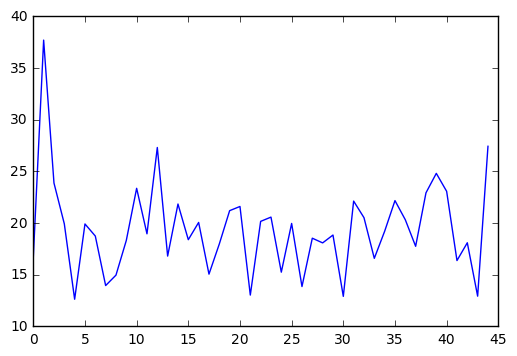

In [150]:
size = 5
train_vals =  (X_14['week'] <= size)
X_train, y_train = X_14[train_vals], y_14[train_vals]

res = []

rf_model.fit(X_train[features], y_train)

for i in range(size + 1, 51):
        
    test_vals = (X_14['week'] == i)
    X_val, y_val = X_14[test_vals], y_14[test_vals]

        
    y_pred = rf_model.predict(X_val[features])
    
    res.append(get_smape(y_pred, y_val))

plt.plot(res)

In [109]:
def my_cross_validation(model, features, f=lambda x: x, inv=lambda x: x):
    cv = []
    for fold in [20, 30, 40]:
        
        train_vals = X_14['week'] <= fold
        X_train, y_train = X_14[train_vals], y_14[train_vals]
        
        test_vals = (X_14['week'] > fold) & (X_14['week'] <= fold + 10)
        X_val, y_val = X_14[test_vals], y_14[test_vals]
        
        model.fit(X_train[features], f(y_train))
        
        y_pred = model.predict(X_val[features])
        
        cv.append(get_smape(inv(y_pred), y_val))
        
    return cv

In [239]:
%%time
cv = my_cross_validation(rf_model, features)
print(cv)

[9.4106218557152506, 11.571065672062668, 14.897333727267171]
CPU times: user 2min 20s, sys: 1.2 s, total: 2min 21s
Wall time: 2min 29s


In [252]:
%%time
cv = my_cross_validation(rf_model, features, np.log, np.exp)
print(cv)

[9.2360837860543814, 11.081189051954642, 14.063932545790538]
CPU times: user 2min 17s, sys: 2.33 s, total: 2min 20s
Wall time: 2min 38s


In [253]:
%%time
rf_model = RandomForestRegressor(n_estimators=1000)
cv = my_cross_validation(rf_model, features, np.log, np.exp)
print(cv)

[9.2268165148619055, 11.062919227203171, 14.062203114591687]
CPU times: user 3min 11s, sys: 3.62 s, total: 3min 14s
Wall time: 3min 39s


In [268]:
%%time
rf_model = RandomForestRegressor(n_estimators=1000)
cv = my_cross_validation(rf_model, features, lambda x: np.log(x + 1), lambda x: np.exp(x) - 1)
print(cv)

[9.2135936606397291, 11.067382395644351, 14.042284714545389]
CPU times: user 3min 1s, sys: 2.55 s, total: 3min 3s
Wall time: 3min 15s


In [223]:
%%time 

rf_model = RandomForestRegressor(n_estimators=700, oob_score = True)
rf_model.fit(X_14[features], y_14)

CPU times: user 1min 24s, sys: 1.11 s, total: 1min 25s
Wall time: 1min 36s


In [52]:
def add_shift(model, features, is_df=False):
    test_mod = test[test['shift'] == 1].drop(['Num', 'shift'], axis=1)
    if (is_df):
        to_test = xgb.DMatrix(data = test_mod[features])
        predicted = model.predict(to_test)
    else:
        predicted = model.predict(test_mod[features])
    all_predicted_dict = {}
    all_predicted = []
    i = 0
    for _, row in test_mod.iterrows():
        all_predicted_dict[(row.item_id, row.week)] = predicted[i]
        i += 1
    for _, row in test.iterrows():
        all_predicted.append(all_predicted_dict[(row.item_id, row.week)])
    return all_predicted / best_k

In [53]:
# to_fit = X_14['week'] >= 40
# rf_model.fit(X_14[to_fit][features], y_14[to_fit])
sample_submission['y'] = add_shift(bst, features, True)

In [32]:
def add_bad(submission):
    bad_ids = {}
    bad_nums = {}
    for item_id in test['item_id'].unique():
        if (test[test['item_id'] == item_id].shape[0] != 3):
            bad_ids[item_id] = np.mean(test[test['item_id'] == item_id]['f60']) + 10.0

    for _, row in test.iterrows():
        if row.item_id in bad_ids:
            bad_nums[row.Num] = bad_ids[row.item_id]
    
    for i, row in submission.iterrows():
        if row.Num in bad_nums:
            submission.set_value(i, 'y', bad_nums[row.Num])
            

In [125]:
def add_good(submission):
    ans = {}
    for item_id in test['item_id'].unique():
        if test[(test['item_id'] == item_id) & (test['week'] == 5) & (test['shift'] == 1)].shape[0] == 1:
            ans[(item_id, 4)] = \
                np.array(test[(test['item_id'] == item_id) & \
                              (test['week'] == 5) & \
                              (test['shift'] == 1)]['f60'])[0] / best_k
            ans[(item_id, 3)] = \
                np.array(test[(test['item_id'] == item_id) & \
                              (test['week'] == 5) & \
                              (test['shift'] == 1)]['f59'])[0] / best_k
        elif test[(test['item_id'] == item_id) & (test['week'] == 4) & (test['shift'] == 1)].shape[0] == 1:
            ans[(item_id, 3)] = \
                np.array(test[(test['item_id'] == item_id) & \
                              (test['week'] == 4) & \
                              (test['shift'] == 1)]['f60'])[0] / best_k
            
    for i, row in test.iterrows():
        if (row.item_id, row.week) in ans:
            submission.set_value(i, 'y', int(ans[(row.item_id, row.week)]))

In [130]:
add_good(sample_submission)

In [54]:
sample_submission

,Num,y
0,348622,1840.531372
1,348623,30782.312500
2,348624,310838.406250
3,348625,35613.734375
4,348626,163.086380
5,348627,121895.007812
6,348628,85186.328125
7,348629,84447.046875
8,348630,91909.578125
9,348631,1873.335205


In [55]:
sample_submission.to_csv('xgb_overfit_submission_1.tsv', sep=',', index=False)

In [121]:
X_13.head()

,year,week,item_id,f1,f2,f3,f4,f5,f6,f7,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
696,2013,1,20442092,270.0,980.0,6140.0,8292.0,780.0,426.0,120.0,...,370.0,151.0,220.0,220.0,450.0,290.0,240.0,210.0,830.0,730.0
697,2013,1,20442091,670.0,2830.0,11530.0,10397.0,260.0,960.0,760.0,...,460.0,400.0,350.0,500.0,480.0,505.0,310.0,230.0,930.0,730.0
698,2013,1,20442076,38056.0,40185.0,45733.0,59710.0,39982.0,45846.0,43680.0,...,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0,76670.0
699,2013,1,20441997,18817.0,20110.0,26368.0,31412.0,23182.0,24565.0,27075.0,...,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0,36280.0
700,2013,1,20441990,47480.0,47619.0,89708.0,166338.0,37620.0,85607.0,92461.0,...,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0,101820.0


In [151]:
X_14.iloc[0]['prev_f59']

869.38824759426757

In [148]:
y_14.iloc[0]

941

In [145]:
X_14.iloc[0]

year        2.014000e+03
week        1.000000e+00
item_id     2.044232e+07
f1          8.291388e+02
f2          9.418373e+02
f3          1.231633e+03
f4          9.498872e+02
f5          7.405900e+02
f6          7.405900e+02
f7          8.130390e+02
f8          9.981865e+02
f9          1.078685e+03
f10         9.015878e+02
f11         9.981865e+02
f12         1.135035e+03
f13         1.215534e+03
f14         5.554425e+02
f15         1.038436e+03
f16         1.135035e+03
f17         9.096377e+02
f18         1.263833e+03
f19         4.668937e+02
f20         9.981865e+02
f21         7.969392e+02
f22         1.529479e+03
f23         3.300455e+02
f24         1.416781e+03
f25         1.424831e+03
f26         1.585829e+03
f27         6.761909e+02
                ...     
f37         8.130390e+02
f38         9.981865e+02
f39         1.078685e+03
f40         9.015878e+02
f41         9.981865e+02
f42         1.135035e+03
f43         1.215534e+03
f44         5.554425e+02
f45         1.038436e+03


(array([    6.,   185.,   231.,   597.,  1290.,  1615.,  2747.,  2591.,
         1592.,   318.]),
 array([  0.69314718,   2.17711137,   3.66107556,   5.14503975,
          6.62900394,   8.11296813,   9.59693233,  11.08089652,
         12.56486071,  14.0488249 ,  15.53278909]),
 <a list of 10 Patch objects>)

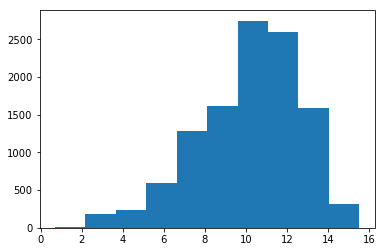

In [267]:
plt.hist(np.log(1 + y_14))

In [248]:
np.log(y_14)

36242     6.846943
36243     6.453625
36244     7.012115
36245     9.617071
36246     8.203578
36247    10.480269
36248     9.473320
36249     3.465736
36250    10.589560
36251     2.772589
36252    10.458521
36253    12.151854
36254    14.079077
36255    13.267497
36256    14.618260
36257    12.922018
36258    10.170227
36259    14.506457
36260    10.934196
36261    13.046626
36262    11.350301
36263     8.860925
36264     8.511980
36265    11.460526
36266    11.470133
36267    10.623058
36268    11.393894
36269     9.069928
36270    12.740130
36271    10.656365
           ...    
69285     3.465736
69286    12.526441
69287     9.868793
69288     5.451038
69289     2.772589
69290    10.053845
69291     5.996452
69292     4.158883
69293     6.669498
69294     6.073045
69295    11.727650
69296    13.515954
69297    12.663596
69298    13.332060
69299    10.198766
69300     7.075809
69301    10.485228
69302    11.822049
69303    13.258552
69304     4.718499
69305     6.244167
69306     6.

In [229]:
test.head()

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f57,f58,f59,f60,prev_f55,prev_f56,prev_f57,prev_f58,prev_f59,prev_f60
0,348622,2015,3,3,20447918,1545.579107,1320.182154,1816.055451,2899.570804,1682.427257,...,1902.994275,1642.177801,2081.701860,2076.871925,2092.971707,2833.561696,1690.477148,1143.084548,1143.084548,2109.071490
1,348623,2015,3,3,20447902,14628.262255,20261.576104,18667.697650,15592.639218,20796.088878,...,27240.831758,29494.801289,38826.235146,34303.806281,20052.278933,23248.085732,13906.992005,7132.203587,14924.498250,14811.799774
2,348624,2015,3,3,20447732,185287.565279,237128.864488,283460.818172,230395.935504,325326.692228,...,332777.671506,395494.373700,460741.961682,460299.217667,174668.148833,202915.216989,172518.827887,60327.494492,103668.108613,113390.767182
3,348625,2015,3,3,20443951,33648.545138,39315.668530,43578.890900,32940.154714,41183.243284,...,24726.045753,30476.888013,47724.584858,54690.960687,42442.246265,46930.865588,31491.174302,17436.064299,31029.110548,27965.321964
4,348626,2015,3,3,20443944,7132.203587,9440.912378,5329.027962,2983.289672,4565.898278,...,32.199565,48.299347,0.000000,0.000000,7244.902063,11192.568699,8690.662519,6488.212292,5892.520345,6473.722488
